In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from scipy.io import mmread, mmwrite
import matplotlib.pyplot as plt
# from scipy import sparse
import plotly.express as px
import random
import math
import seaborn as sns
from plotly import graph_objects as go
from sklearn.decomposition import PCA
from numpy import random
from scipy.sparse.linalg import svds
from plotly.subplots import make_subplots

Repurposing some code from the resampling SBM work

In [2]:
# Network generation --------------------------------------------------------

random.seed(10)

n = 30  # number of nodes
T = 4     # number of time points
K = 2     # number of node communities

# Community labels
tau = np.random.choice(K, n) # order tau would make the nice blocks
tau = np.sort(tau)
# print(tau)

# Generate stochastic block model (SBM) B matrices
# The first row/column stays the same, so the first community shouldn't move
# The second row/column changes, so we expect the second community to move
B_list = []
B_list.append(np.array([[0.4, 0.2], [0.2, 0.3]]))
B_list.append(np.array([[0.4, 0.2], [0.2, 0.3]]))
B_list.append(np.array([[0.4, 0.2], [0.2, 0.45]]))
B_list.append(np.array([[0.4, 0.2], [0.2, 0.45]]))


In [4]:
# Generate adjacency matrices from the B matrices
As = np.zeros((T, n, n))
P_list = []

In [5]:
random.seed(10)
for t in range(T):
    # Get probability matrix from B
    P_t = np.column_stack(
        [B_list[t][tau, tau[i]] for i in range(n)])
    P_list.append(P_t)

    # Generate random graph from the P matrix
    """Have modified this to be a draw for integers between 0 and 10 for no. connections"""
    A_t = np.random.binomial(n=10, p=P_t)
    # turn to integer from float
    A_t = A_t.astype(int)
    As[t] = A_t

As = As.astype(int)
P = np.column_stack(P_list)

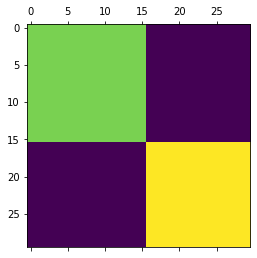

In [6]:
# True P for the last t in the loop
plt.matshow(P_t)

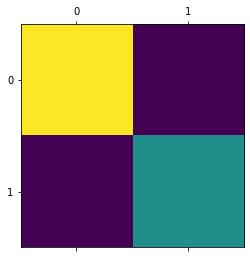

In [7]:
plt.matshow(B_list[1])

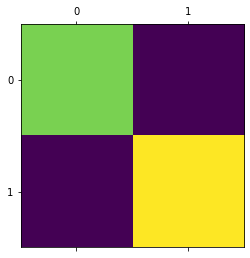

In [8]:
plt.matshow(B_list[2])
plt.savefig('B_matrix_heatmap.pdf')

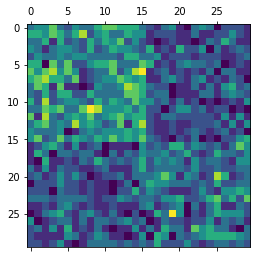

In [9]:
# Sample drawn using the above P in a Binom(10, P) 
plt.matshow(As[1])

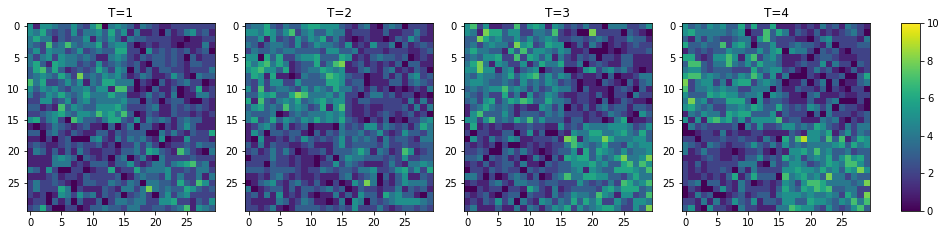

In [10]:
fig, axes = plt.subplots(1,5, figsize=(16,5), gridspec_kw={'width_ratios': [1]*4 + [0.1]})
axes[-1].set_box_aspect(10)

for i, ax in enumerate(axes[:-1]):
    ax.set_title(f'T={i+1}')
    # ax.matshow(As[i])
    cx = ax.imshow(As[i], vmax=10)

#cx = axes[-1].matshow(As[3], vmax=10)
fig.colorbar(cx, cax=axes[-1])


In [10]:
fig.savefig('SBM_2comm_matrixHeatmaps.pdf')

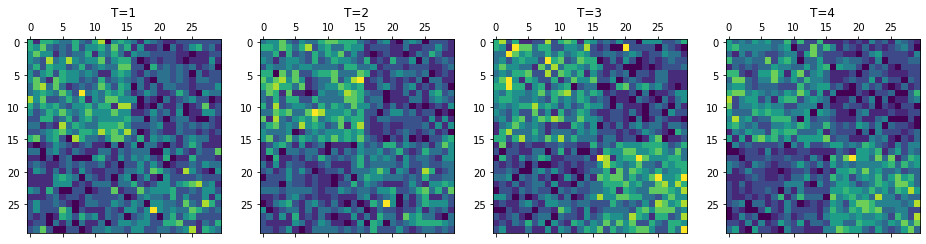

In [11]:
fig, (ax0, ax1, ax2, ax3) = plt.subplots(1,4, figsize=(16,5))

# fig.suptitle('Heatmaps of the `A` matrices which have SBM format of 2 communities', fontsize=12)

ax0.set_title('T=1')
ax0.matshow(As[0])
ax1.set_title('T=2')
ax1.matshow(As[1])
ax2.set_title('T=3')
ax2.matshow(As[2])
ax3.set_title('T=4')
ax3.matshow(As[3])

# fig.savefig('SBM_2comm_matrixHeatmaps.pdf')

In [11]:
# Construct the unfolded adjacency matrix
A = As[0, :, :]
for t in range(1, T):
    A = np.block([A, As[t]])

In [13]:
A.shape

(30, 120)

Now we have (for a set seed), some "observed" $A^{(t)}$ matrices, where we know the $P$ matrices that they are drawn from. 

We then want to see how much of our A are non-zero values, and then apply bootstrap resampling to these matrices. 
As[0] is $A^{(1)}$, As[1] is $A^{(2)}$.

### Embed the T=4 unfolded A matrix with UASE

In [13]:
A = A.astype(float)
u, s, vt = svds(A, 29)
v = vt.T
d = 3
s_idx = np.argsort(s)[::-1][0:d]
ya = v[:, s_idx] @ np.diag(np.sqrt(s[s_idx]))

In [14]:
yadf = pd.DataFrame(ya)

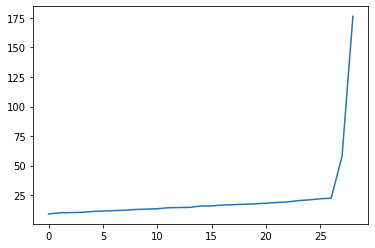

In [16]:
plt.plot(s)

In [15]:
s_desc = np.flip(s)
type(s_desc)

numpy.ndarray

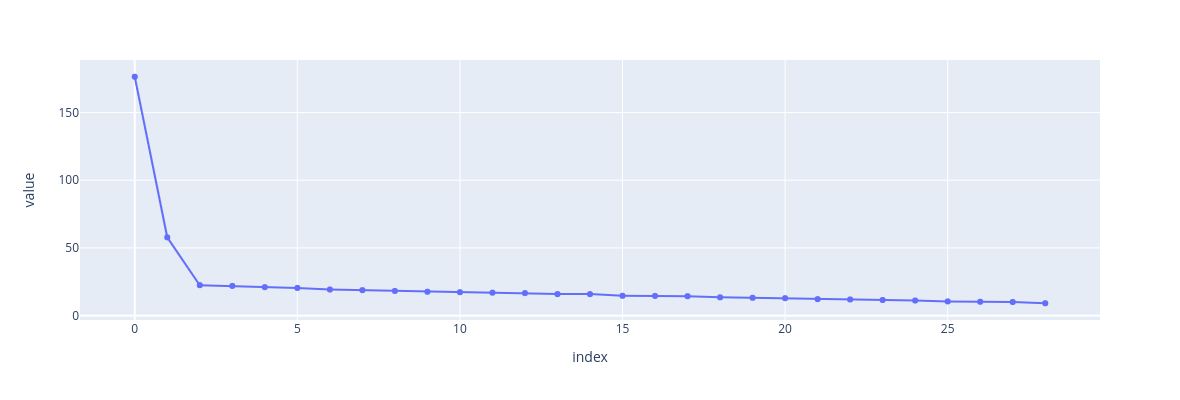

[41289:0123/121344.872425:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [24]:
fig = px.line(s_desc, markers=True, width =500, height=400)
fig.update_layout(showlegend=False)
fig.show()
fig.write_image('screePlot_SBM2example.pdf')

In [16]:
# rename the columns - this is called a list comprehension
yadf.columns = ["dim{}".format(i+1) for i in range(d)] 

# add a year column that repeats each value n times before moving on to the next value
year_list = [2018,2019,2020,2021]
yadf["year"] = np.repeat(year_list, n)

# repeats tau array T times for which community node is in
yadf["community"] = list(tau)*T # .values to make in a np array

In [30]:
yadf.head(3)

dim1      dim2      dim3  year  community
0  1.217810 -0.704812  0.446965  2018          0
1  1.253392 -0.415929 -0.008200  2018          0
2  1.216918 -0.744291  0.021426  2018          0

In [17]:
ladslist = pd.read_csv("LADS_list.csv", header=None)

ladslist = ladslist[1]
ladslist = list(ladslist.loc[0:(n-1)]) # just yse the names of the 30 first LADs as we have 30 nodes
len(ladslist)

30

In [18]:
df = yadf
df['NorthIndicator'] = df['community']
df['LAD'] = list(ladslist)*T

This is calling something else `n` now

In [19]:
# how many LADs are in the north
n = df[(df["year"]==2018) & (df["NorthIndicator"]==1)].shape[0]
# how many LADs are in the south
s = df[(df["year"]==2018) & (df["NorthIndicator"]==0)].shape[0]

print([n,s])

[14, 16]


In [20]:
d = 3 # we chose this from the scree plots - here i know d=2 is better as i picked 2 communities

years = df["year"].unique()
earlyYears = years[0:2] # 2018-2019
lateYears = years[2:4]  # 2020-2021

In [21]:
mean_diff_early = []
mean_diff_late = []

In [22]:
# make a column that is 1 if the year is an "early year"
df["EarlyIndicator"] = np.where( (df["year"] == earlyYears[0]) | (df["year"] == earlyYears[1]) , 1, 0) 
earlyNorthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 1) ]
earlySouthdf = df[ (df["EarlyIndicator"] == 1) & (df["NorthIndicator"] == 0) ]
lateNorthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 1) ]
lateSouthdf = df[ (df["EarlyIndicator"] == 0) & (df["NorthIndicator"] == 0) ]

In [24]:
# calculate values of mean_diff_early_i for all i, i.e. all PCs, and store them in order in a vector
# same for mean_diff_late_i

for i in range(0,d):
    valEarly = (1/3*n) * sum( earlyNorthdf.iloc[: ,i])  -  (1/3*s) * sum( earlySouthdf.iloc[: ,i])
    valLate = (1/3*n) * sum( lateNorthdf.iloc[: ,i])  -  (1/3*s) * sum( lateSouthdf.iloc[: ,i])
    mean_diff_early.append(valEarly)
    mean_diff_late.append(valLate)

In [25]:
# calculate T_PC_i
T_PC = np.subtract(mean_diff_early, mean_diff_late)

# length d vector of the subtracted values
T_PC

array([ 33.677176  , -75.61891089,  -3.43793591,  33.677176  ,
       -75.61891089,  -3.43793591])

In [26]:
T_full_obs = sum(T_PC**2) # this is T_obs
T_obs = T_full_obs # incase I type wrong thing
T_full_obs

13728.382541256069

#### Permute assignments of LADs into before/after independently

If the null hypothesis says that time doesn't matter, the labelling of columns into positions shouldn't matter. So we can permute the assignments.
Each LAD is counted exactly 3 times in the early/late groups, which we might label A and B when permuting to avoid confusion. Which groups the LADs columns are assigned to are done **independently** for each LAD.

#### Put it all together in a loop that iterates P times, and stores P items in a `T_full_p_list` item. 

In [27]:
rand_ones = np.array([0,0,1,1]) # T=4
df["A_indicator"] = 0

T_full_p_list = []
P = 5000

# for the individual PCs
T_PC_p_table = pd.DataFrame(columns=['dim1','dim2','dim3'])

The cell below takes ~5mins to run when $p=5000$.

In [28]:
summariesdf = pd.DataFrame()

for p in range(P):

    for lad in ladslist:
        # to pick 3 timepoints at random for group A
        random.shuffle(rand_ones)
        # populates the "A_indicator" column
        df.loc[df["LAD"] == lad,"A_indicator"] = rand_ones

# split the data into the 4 groups (made up of 2 binary labels, 2*2 = 4)
    A_Northdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 1) ]
    A_Southdf = df[ (df["A_indicator"] == 1) & (df["NorthIndicator"] == 0) ]
    B_Northdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 1) ]
    B_Southdf = df[ (df["A_indicator"] == 0) & (df["NorthIndicator"] == 0) ]
    
    ### THIS STUFF IS TO CONSTRUCT CONFIDENCE INTERVALS
    A_North_summaries = [np.mean(A_Northdf['dim1']) , np.mean(A_Northdf['dim2']) , np.mean(A_Northdf['dim3']) ]
    A_South_summaries = [np.mean(A_Southdf['dim1']) , np.mean(A_Southdf['dim2']) , np.mean(A_Southdf['dim3']) ]
    B_North_summaries = [np.mean(B_Northdf['dim1']) , np.mean(B_Northdf['dim2']) , np.mean(B_Northdf['dim3']) ]
    B_South_summaries = [np.mean(B_Southdf['dim1']) , np.mean(B_Southdf['dim2']) , np.mean(B_Southdf['dim3']) ]
    summaries = pd.DataFrame (A_North_summaries, columns = ['A_North'])
    summaries['A_South'] = A_South_summaries
    summaries['B_North'] = B_North_summaries
    summaries['B_South'] = B_South_summaries
    summaries.index = (['dim1', 'dim2' , 'dim3'])
    summaries = summaries.transpose()
    summaries['NorthIndicator'] = [1,0,1,0]
    summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
    summaries['A_Indicator'] = [1,1,0,0]
    summaries['AorB'] = np.where(summaries['A_Indicator'] >0, 'A', 'B')
    summaries['permutation'] = p
    summariesdf = pd.concat([summariesdf, summaries], axis=0)


    # length d vectors of the difference between the mean locations of the North and South for the 2 groups, A and B 
    mean_diff_A_p = []  #A is early, B is late
    mean_diff_B_p = []
    # calculate values of mean_diff_A_i for all i, i.e. all PCs, and store them in order in a vector
    # same for mean_diff_B_i
    for i in range(0,d):
        valA = (1/3*n) * sum( A_Northdf.iloc[: ,i])  -  (1/3*s) * sum( A_Southdf.iloc[: ,i])
        valB = (1/3*n) * sum( B_Northdf.iloc[: ,i])  -  (1/3*s) * sum( B_Southdf.iloc[: ,i])
        mean_diff_A_p.append(valA)
        mean_diff_B_p.append(valB)

    # calculate T_PC_i_p
    T_PC_p = np.subtract(mean_diff_A_p, mean_diff_B_p)

    T_full_p = sum(T_PC_p**2) # this is T_obs

    # values for all dimensions statistic 
    T_full_p_list.append(T_full_p)
    
    # values for individual dimension statistic
    T_PC_p_table.loc[p,:] = T_PC_p

In [29]:
counter = 0
for p in range(P):
    if T_full_p_list[p] > T_obs:
        counter += 1
    else: 
        counter = counter

In [30]:
# how many of the P permutations had a distance larger than T_obs
counter

0

p-value for testing change across all dimensions:

In [31]:
# because we consider:
# p-value = (1/(P+1)) #test statistics >= T_obs 
# where T_obs and T_p are all considered.
(counter+1)/(P+1)

0.0001999600079984003

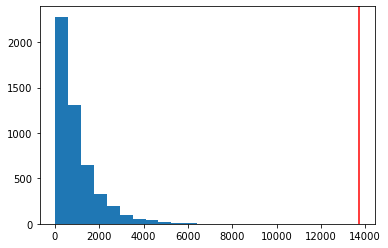

In [32]:
plt.hist(T_full_p_list, bins=20)
plt.axvline(T_obs,color='red')

This is across all d=4 embedding dimensions. We should split this out now to have 4 T_obs, one for each PC, and then get P replicates of T_PC_i

#### Testing if time matters in each of the 4 dimensions independently
I think we can do this as the dimensions are orthogonal

In [33]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table.iloc[p , dim] > T_PC[dim]:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_values = [x / (P+1) for x in counters_PCs]
PC_p_values

[0.0, 0.9998000399920016, 0.5640871825634873]

In [34]:
# can square all the values in the `T_PC_p_table` table.
# This is to say we are looking at the value of   (mean_diff_A_p_i - mean_diff_B_p_i)**2
# when we look at row p, column i in the table

T_PC_p_table_squared = T_PC_p_table**2 # #square every value in df

Histograms for *mean_diff_A_p_i - mean_diff_B_p_i*, where there is a plot for each `i` (the dimension), and `P` counts. 

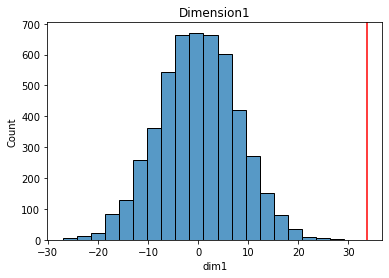

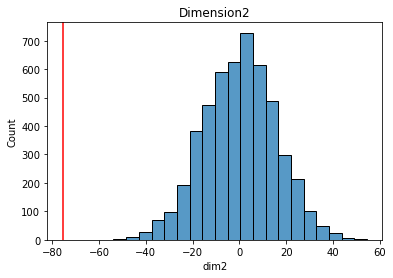

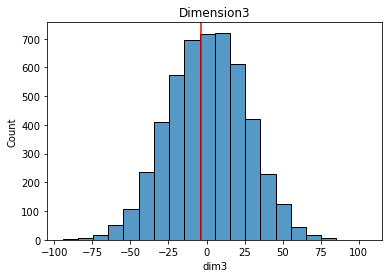

In [35]:
for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table.iloc[:,dim], bins=20)
    plt.axvline(T_PC[dim], color="red")
    ax.set_title("Dimension{}".format(dim+1))
    
    fig = ax.get_figure()

### Histograms for *(mean_diff_A_p_i - mean_diff_B_p_i)$^2$*, where there is a plot for each `i` (the dimension), and `P` counts. 

In [36]:
counters_PCs = []
for dim in range(d):
    counter = 0
    for p in range(P):
        if T_PC_p_table_squared.iloc[p , dim] > (T_PC[dim])**2:
            counter += 1
        else: 
            counter = counter
    counters_PCs.append(counter)

PC_p_square_values = [x / (P+1) for x in counters_PCs]

# p-values for each dimension
PC_p_square_values

[0.0, 0.0, 0.9012197560487902]

Tells us at the 5% significance level, we can see that only a significant change for PC1 and PC2 in that we see a change between the 
**early** years and the **late** years.


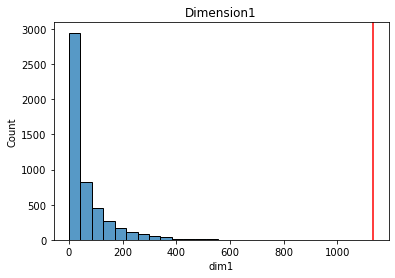

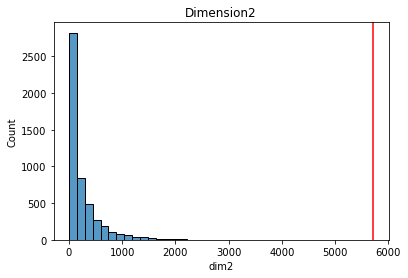

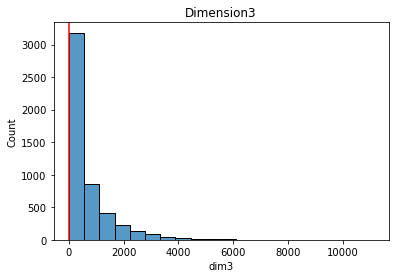

In [50]:
# squared values of distance between mean diff in groups A and B

for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.histplot(T_PC_p_table_squared.iloc[:,dim], bins=20)
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title("Dimension{}".format(dim+1))
    
    fig = ax.get_figure()

    fig.savefig("simulationHistogramPlots_Dim{}.pdf".format(dim+1))

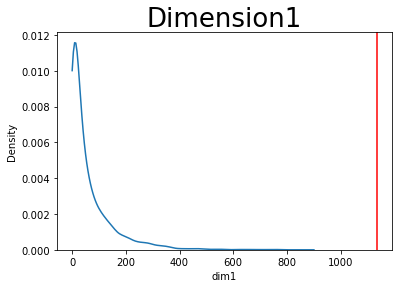

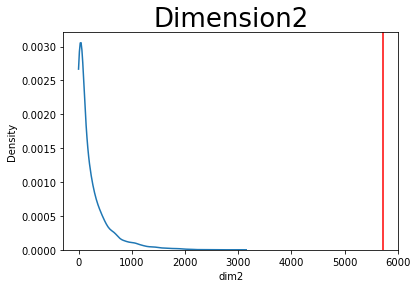

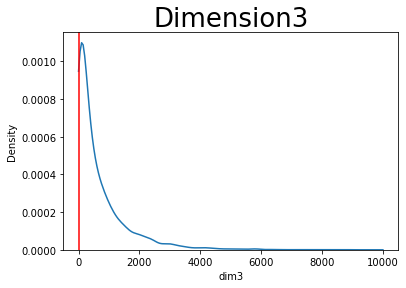

In [55]:
for dim in range(d):
    f, ax = plt.subplots()
    ax = sns.kdeplot(T_PC_p_table_squared.iloc[:,dim] , clip=(0.0, 10000))
    plt.axvline( (T_PC[dim])**2 , color="red")
    ax.set_title("Dimension{}".format(dim+1), fontsize=26)
    
    fig = ax.get_figure()

    fig.savefig("simulationDensityPlots_Dim{}.pdf".format(dim+1))

### Plots and Summary Statistics
06/10/2022

In [37]:
earlyNorth_summaries = [np.mean(earlyNorthdf['dim1']) , np.mean(earlyNorthdf['dim2']) , np.mean(earlyNorthdf['dim3']) ]
earlySouth_summaries = [np.mean(earlySouthdf['dim1']) , np.mean(earlySouthdf['dim2']) , np.mean(earlySouthdf['dim3']) ]
lateNorth_summaries = [np.mean(lateNorthdf['dim1']) , np.mean(lateNorthdf['dim2']) , np.mean(lateNorthdf['dim3']) ]
lateSouth_summaries = [np.mean(lateSouthdf['dim1']) , np.mean(lateSouthdf['dim2']) , np.mean(lateSouthdf['dim3']) ]

In [38]:
summaries = pd.DataFrame (earlyNorth_summaries, columns = ['earlyNorth'])
summaries['earlySouth'] = earlySouth_summaries
summaries['lateNorth'] = lateNorth_summaries
summaries['lateSouth'] = lateSouth_summaries

summaries.index = (['dim1', 'dim2' , 'dim3'])

summaries = summaries.transpose()

summaries['NorthIndicator'] = [1,0,1,0]
summaries['NorthorSouth'] = np.where(summaries['NorthIndicator'] >0, 'North', 'South')
summaries['EarlyIndicator'] = [1,1,0,0]
summaries['EarlyorLate'] = np.where(summaries['EarlyIndicator'] >0, 'Early', 'Late')

In [43]:
summariesdf

dim1      dim2      dim3  NorthIndicator NorthorSouth  \
A_North  1.137553  0.733492  0.045858               1        North   
A_South  1.286979 -0.571380  0.040048               0        South   
B_North  1.090338  0.683067 -0.014831               1        North   
B_South  1.269842 -0.562780 -0.048392               0        South   
A_North  1.111527  0.651729 -0.026094               1        North   
...           ...       ...       ...             ...          ...   
B_South  1.274772 -0.569475 -0.072633               0        South   
A_North  1.120000  0.646572  0.047082               1        North   
A_South  1.303325 -0.576584 -0.031916               0        South   
B_North  1.107891  0.769987 -0.016055               1        North   
B_South  1.253495 -0.557577  0.023571               0        South   

         A_Indicator AorB  permutation  
A_North            1    A            0  
A_South            1    A            0  
B_North            0    B            0  
B_South            0    B            0  
A_North            1    A            1  
...              ...  ...          ...  
B_South            0    B         4998  
A_North            1    A         4999  
A_South            1    A         4999  
B_North            0    B         4999  
B_South            0    B         4999  

[20000 rows x 8 columns]

In [39]:
summariesdf['ABNorthSouth'] = summariesdf['NorthorSouth'] + summariesdf['AorB'] 

In [42]:
# LABEL THEM C1 AND C2 RATHER THAN NORTH/SOUTH FOR SOME PLOTS
summaries['C1orC2'] = summaries['NorthorSouth'] # replicate
summaries['C1orC2'] = np.where(summaries['C1orC2'] == 'South', 'C1', 'C2')


dim1      dim2      dim3  NorthIndicator NorthorSouth  \
earlyNorth -0.989233  0.416174  0.025619               1        North   
earlySouth -1.281591 -0.569184  0.013637               0        South   
lateNorth  -1.238658  1.000385  0.005407               1        North   
lateSouth  -1.275230 -0.564976 -0.021982               0        South   

            EarlyIndicator EarlyorLate C1orC2  
earlyNorth               1       Early     C2  
earlySouth               1       Early     C1  
lateNorth                0        Late     C2  
lateSouth                0        Late     C1

In [46]:
fig1_2 = px.line(summaries, x='dim1', y='dim2', 
              color='C1orC2', markers=True,
              text='EarlyorLate',
                hover_data=['C1orC2', 'EarlyorLate'],
                labels = {
                    "dim1": "Dimension 1", 
                    "dim2": "Dimension 2"},
                 title = "Dimension 1 vs Dimension 2",
             width=500, height=500)

fig1_2.update_traces(textposition='top center')

fig1_2.show()

fig1_2.write_image('SBM2comm_1_2.pdf', width=450, height=450)

[241585:0928/095415.573587:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command
[241585:0928/095423.047289:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [48]:
# LABEL THEM C1 AND C2 RATHER THAN NORTH/SOUTH FOR SOME PLOTS
summariesdf['C1orC2'] = summariesdf['NorthorSouth'] # replicate
summariesdf['C1orC2'] = np.where(summariesdf['C1orC2'] == 'South', 'C1', 'C2')

# also T1/T1 not A/B
summariesdf['T1orT2'] = summariesdf['AorB'] # replicate
summariesdf['T1orT2'] = np.where(summariesdf['T1orT2'] == 'A', 'T1', 'T2')

summariesdf['T1orT2andC1orC2'] = summariesdf['C1orC2'] + summariesdf['T1orT2'] 

In [51]:
summariesdf

dim1      dim2      dim3  NorthIndicator NorthorSouth  \
A_North -1.137553  0.733492  0.045858               1        North   
A_South -1.286979 -0.571380  0.040048               0        South   
B_North -1.090338  0.683067 -0.014831               1        North   
B_South -1.269842 -0.562780 -0.048392               0        South   
A_North -1.111527  0.651729 -0.026094               1        North   
...           ...       ...       ...             ...          ...   
B_South -1.274772 -0.569475 -0.072633               0        South   
A_North -1.120000  0.646572  0.047082               1        North   
A_South -1.303325 -0.576584 -0.031916               0        South   
B_North -1.107891  0.769987 -0.016055               1        North   
B_South -1.253495 -0.557577  0.023571               0        South   

         A_Indicator AorB  permutation ABNorthSouth C1orC2 T1orT2  \
A_North            1    A            0       NorthA     C2     T1   
A_South            1    A            0       SouthA     C1     T1   
B_North            0    B            0       NorthB     C2     T2   
B_South            0    B            0       SouthB     C1     T2   
A_North            1    A            1       NorthA     C2     T1   
...              ...  ...          ...          ...    ...    ...   
B_South            0    B         4998       SouthB     C1     T2   
A_North            1    A         4999       NorthA     C2     T1   
A_South            1    A         4999       SouthA     C1     T1   
B_North            0    B         4999       NorthB     C2     T2   
B_South            0    B         4999       SouthB     C1     T2   

        T1orT2andC1orC2  
A_North            C2T1  
A_South            C1T1  
B_North            C2T2  
B_South            C1T2  
A_North            C2T1  
...                 ...  
B_South            C1T2  
A_North            C2T1  
A_South            C1T1  
B_North            C2T2  
B_South            C1T2  

[20000 rows x 12 columns]

In [73]:
fig1_2a = px.scatter(summariesdf, x="dim1", y="dim2",
                 color ="T1orT2andC1orC2", opacity=0.2, 
                 height=500, width=500)

fig1_2b = px.line(summaries, x='dim1', y='dim2', 
              color='C1orC2', markers=True,
              text='EarlyorLate',
                hover_data=['C1orC2', 'EarlyorLate'])

fig1_2b.update_traces(textposition='top center')

layout = go.Layout(
    title="Dimension 1 vs Dimension 2 <br> with Permutation Points sampled under Null",
    xaxis=dict(
        title="Dimension 1"
    ),
    yaxis=dict(
        title="Dimension 2"
    ) ) 
fig1_2c = go.Figure(data=fig1_2a.data + fig1_2b.data, layout=layout)

fig1_2c.show()

fig1_2c.write_image('SBM2comm_1_2_clouds.pdf', width=450, height=450)

[241585:0928/102016.385887:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [58]:
fig1_2a = px.line(summaries, x='dim1', y='dim2', 
              color='NorthorSouth', markers=True,
              text='EarlyorLate',
                hover_data=['NorthorSouth', 'EarlyorLate'])

fig1_2b = px.scatter(summariesdf, x="dim1", y="dim2",
                 color ="ABNorthSouth", opacity=0.2,
                 height=500, width=500)

fig1_2b.update_traces(textposition='top center')

layout = go.Layout(
    title="Plot dim1 vs dim2",
    xaxis=dict(
        title="Dimension 1"
    ),
    yaxis=dict(
        title="Dimension 2"
    ) ) 
fig1_2c = go.Figure(data=fig1_2a.data + fig1_2b.data, layout=layout)

fig1_2c.show()

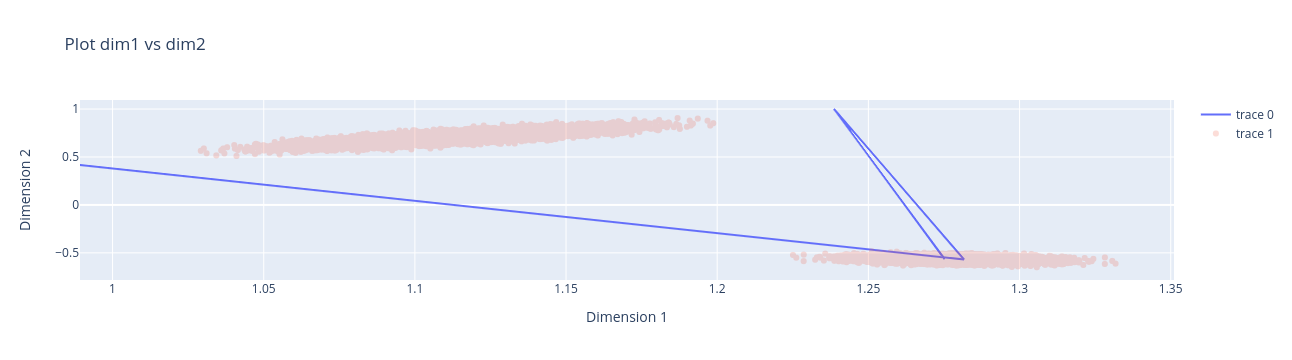

In [116]:
fig1_2a = go.Scatter(x=summaries['dim1'], y=summaries['dim2'], 
              # fill='NorthorSouth', 
                     mode='lines',
              text='EarlyorLate',
                # hover_data=['NorthorSouth', 'EarlyorLate']
                    )

fig1_2b = go.Scatter(x=summariesdf['dim1'], y=summariesdf['dim2'],
                 # color ="ABNorthSouth", 
                     mode='markers', opacity=0.2,
                 # height=500, width=500
                    )

# fig1_2b.update_traces(textposition='top center')

layout = go.Layout(
    title="Plot dim1 vs dim2",
    xaxis=dict(
        title="Dimension 1"
    ),
    yaxis=dict(
        title="Dimension 2"
    ) ) 
fig1_2c = go.Figure(layout=layout)
fig1_2c.add_trace(fig1_2a)
fig1_2c.add_trace(fig1_2b)
fig1_2c.show()

In [72]:
fig2_3 = px.line(summaries, x='dim2', y='dim3', 
              color='C1orC2', markers=True,
              text='EarlyorLate',
                hover_data=['NorthorSouth', 'EarlyorLate'],
                labels = {
                    "dim3": "Dimension 3", 
                    "dim2": "Dimension 2"},
                 title = "Dimension 2 vs Dimension 3",
             width=500, height=500)

fig2_3.update_traces(textposition='top center')


fig2_3.update_layout(yaxis_range=[-0.7, 1.1])
fig2_3.update_layout(xaxis_range=[-0.7, 1.1])

fig2_3.show()


fig2_3.write_image('SBM2comm_2_3.pdf', width=450, height=450)

[241585:0928/101902.149049:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


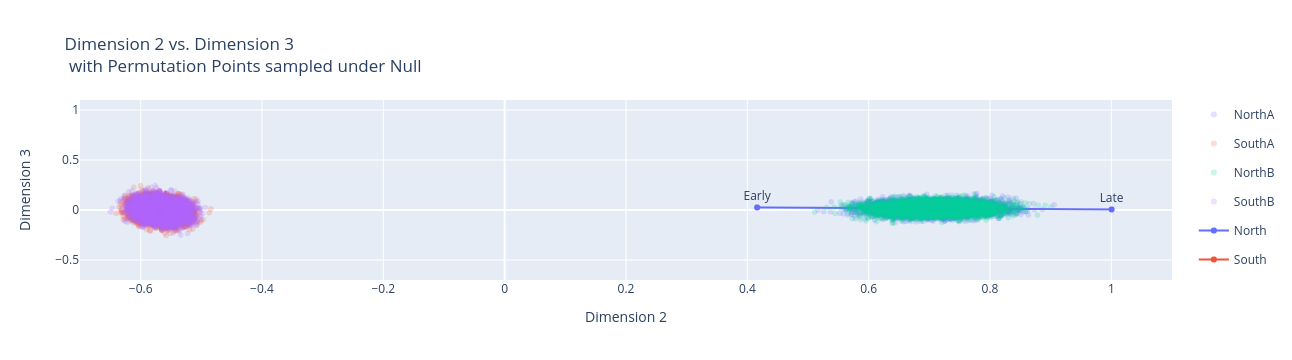

[127540:1107/112059.817174:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [177]:
fig2_3a = px.scatter(summariesdf, x="dim2", y="dim3",
                 color ="ABNorthSouth", opacity=0.2,
                 height=500, width=500)

fig2_3b = px.line(summaries, x='dim2', y='dim3', 
              color='NorthorSouth', markers=True,
              text='EarlyorLate',
                hover_data=['NorthorSouth', 'EarlyorLate'])

fig2_3b.update_traces(textposition='top center')

layout = go.Layout(
    title =  "Dimension 2 vs. Dimension 3 <br> with Permutation Points sampled under Null",
    xaxis=dict(
        title="Dimension 2"
    ),
    yaxis=dict(
        title="Dimension 3"
    ) ) 
fig2_3c = go.Figure(data=fig2_3a.data + fig2_3b.data, layout=layout)
fig2_3c.update_layout(yaxis_range=[-0.7, 1.1])
fig2_3c.update_layout(xaxis_range=[-0.7, 1.1])

fig2_3c.show()

fig2_3c.write_image('SBM2comm_2_3_clouds.pdf', width=450, height=450)

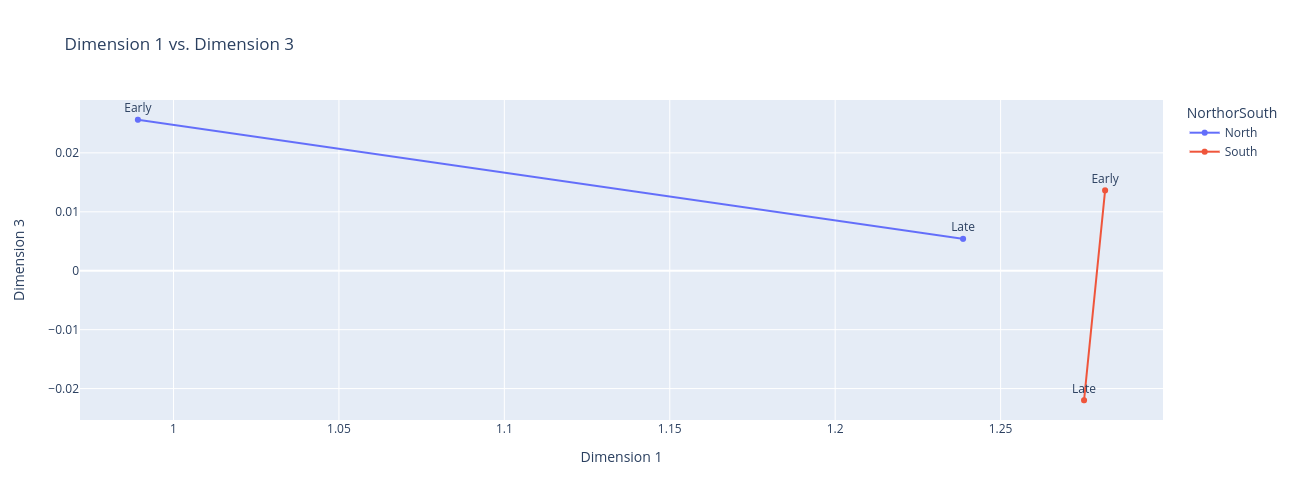

[30145:1109/111819.608246:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [48]:
fig1_3 = px.line(summaries, x='dim1', y='dim3', 
              color='NorthorSouth', markers=True,
              text='EarlyorLate',
                hover_data=['NorthorSouth', 'EarlyorLate'],
                 labels = {
                    "dim3": "Dimension 3", 
                    "dim1": "Dimension 1"},
                 title = "Dimension 1 vs. Dimension 3",
             width=500, height=500)

fig1_3.update_traces(textposition='top center')

fig1_3.show()

fig1_3.write_image('SBM2comm_1_3.pdf', width=450, height=450)

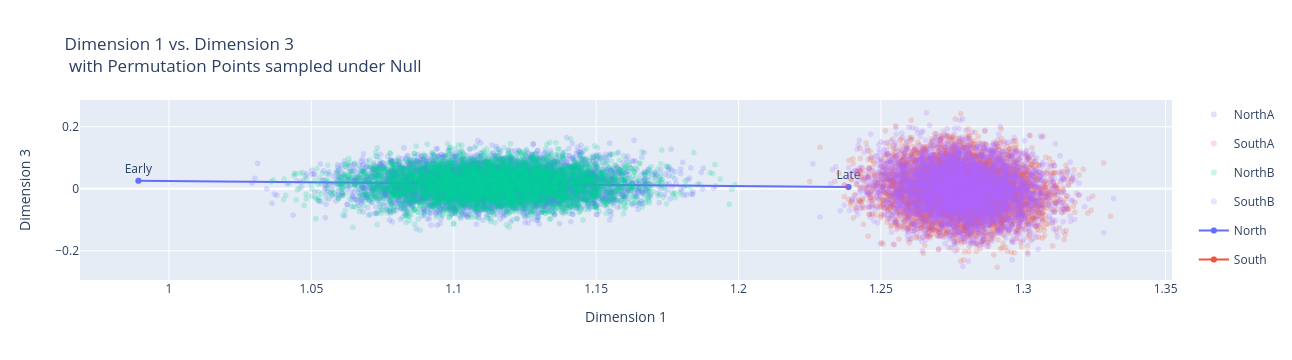

[30145:1109/111858.111703:ERROR:buffer_manager.cc(488)] [.DisplayCompositor]GL ERROR :GL_INVALID_OPERATION : glBufferData: <- error from previous GL command


In [49]:
fig1_3a = px.scatter(summariesdf, x="dim1", y="dim3",
                 color ="ABNorthSouth", opacity=0.2,
                 height=500, width=500)

fig1_3b = px.line(summaries, x='dim1', y='dim3', 
              color='NorthorSouth', markers=True,
              text='EarlyorLate',
                hover_data=['NorthorSouth', 'EarlyorLate'])

fig1_3b.update_traces(textposition='top center')

layout = go.Layout(
    title="Dimension 1 vs. Dimension 3  <br> with Permutation Points sampled under Null",
    xaxis=dict(
        title="Dimension 1"
    ),
    yaxis=dict(
        title="Dimension 3"
    ) ) 
fig1_3c = go.Figure(data=fig1_3a.data + fig1_3b.data, layout=layout)

# fig1_3c.update_layout(yaxis_range=[-0.3, 1.4])
# fig1_3c.update_layout(xaxis_range=[-0.3, 1.4])

fig1_3c.show()

fig1_3c.write_image('SBM2comm_1_3_clouds.pdf', width=450, height=450)

North should move between early and late.
South should **not** move between early and late.
This is from how we constructed the SBM.

SBM, of 2 communities, therefore 2 dimensions fully capsures the network. Any movement of either community seen in dimension 3 is purely noise. 

We see South moving in dims 1 and 2. The North moves very little, and what it does move is captured within the ball of the permutations. 

#### Trying to figure out how to show that the change is significant with plots including permutation data

In [121]:
summariesdf

dim1      dim2      dim3  NorthIndicator NorthorSouth  \
A_North  1.137553  0.733492  0.045858               1        North   
A_South  1.286979 -0.571380  0.040048               0        South   
B_North  1.090338  0.683067 -0.014831               1        North   
B_South  1.269842 -0.562780 -0.048392               0        South   
A_North  1.111527  0.651729 -0.026094               1        North   
...           ...       ...       ...             ...          ...   
B_South  1.274772 -0.569475 -0.072633               0        South   
A_North  1.120000  0.646572  0.047082               1        North   
A_South  1.303325 -0.576584 -0.031916               0        South   
B_North  1.107891  0.769987 -0.016055               1        North   
B_South  1.253495 -0.557577  0.023571               0        South   

         A_Indicator AorB  permutation ABNorthSouth  
A_North            1    A            0       NorthA  
A_South            1    A            0       SouthA  
B_North            0    B            0       NorthB  
B_South            0    B            0       SouthB  
A_North            1    A            1       NorthA  
...              ...  ...          ...          ...  
B_South            0    B         4998       SouthB  
A_North            1    A         4999       NorthA  
A_South            1    A         4999       SouthA  
B_North            0    B         4999       NorthB  
B_South            0    B         4999       SouthB  

[20000 rows x 9 columns]

In [122]:
summariesarray = summariesdf.to_numpy()

In [123]:
summaries_earlyLate_array = summaries.to_numpy()

The north and south always occupy different spaces in the dimension 4, but move further apart when we go from early to late. 

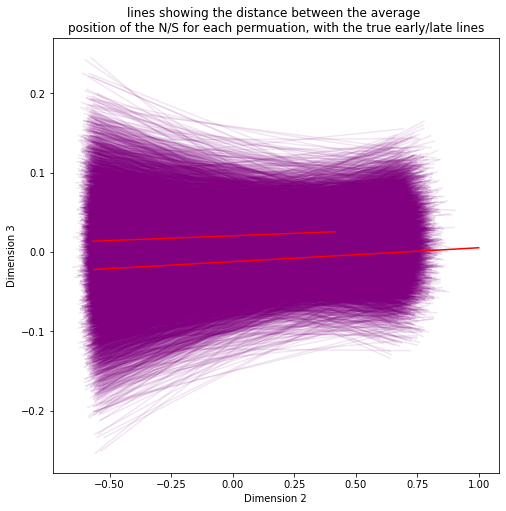

In [124]:
plt.figure(figsize=(8,8))

for i in range(0,summariesdf.shape[0] ,2):#summariesdf.shape[0]
    plt.plot((summariesarray[i,1],summariesarray[i+1,1]), (summariesarray[i,2],summariesarray[i+1,2]), alpha=0.1, color="purple")


plt.plot((summaries_earlyLate_array[0,1],summaries_earlyLate_array[1,1]), (summaries_earlyLate_array[0,2],summaries_earlyLate_array[1,2]), color="red")
plt.plot((summaries_earlyLate_array[2,1],summaries_earlyLate_array[3,1]), (summaries_earlyLate_array[2,2],summaries_earlyLate_array[3,2]), color="red")


plt.xlabel("Dimension 2")
plt.ylabel("Dimension 3")
plt.title("lines showing the distance between the average \nposition of the N/S for each permuation, with the true early/late lines")

plt.savefig("simulations_PC2_3_distanceLines.pdf", bbox_inches='tight')

plt.show()



So whatever variation we see in Dimension 3 is noise. We know that Dimension 2 is where there is actually a difference, so the drastic change in line length tells us that the early and late timepoints are significantly different. 